In [9]:
import numpy as np
from math import *
import matplotlib.cm as cm
import scipy
from scipy.signal import convolve, deconvolve
import matplotlib.pyplot as plt
import matplotlib.animation as animation  
from matplotlib.pyplot import figure
from PIL import Image, ImageDraw
from PIL import ImageFilter
from PIL import ImageColor
from pathlib import Path
import random
from matplotlib.patches import Ellipse
import glob
from skimage.util import random_noise
import time
import sklearn
from sklearn.decomposition import FastICA, PCA

# Dictionary Leaning Algorithm

In [2]:
def S_lamb (x, lamb):
    if np.abs(x) <= lamb:
        return 0
    elif x> lamb:
        return x-lamb
    elif x<-lamb:
        return x+lamb

In [3]:
def proximal_mapping (X, lamb):
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i][j]=S_lamb(X[i][j], lamb)

    return X

In [4]:
# Laplacian matrix

pixel_1 = 50
pixel_2 = 50
tot_pixel = pixel_1*pixel_2 # total number of pixels used for the movie

L = np.zeros((tot_pixel, tot_pixel))

#neighbors of 0
L[0][0]=2
L[0][1]=-1
L[1][0]=-1
L[0][pixel_1] = -1
L[pixel_1][0] = -1

#neighbors of the first line of the image except last element
for i in range(1, pixel_1-1):
    L[i][i]=3
    L[i][i+1]=-1
    L[i+1][i]=-1 
    L[i][pixel_1+i]=-1
    L[pixel_1 + i][i]=-1
    
#neighbors first line last element
L[pixel_1-1][pixel_1-1]=2
L[pixel_1-1][pixel_1-2]=-1
L[pixel_1-2][pixel_1-1]=-1
L[pixel_1-1][2*pixel_1-1]=-1
L[2*pixel_1-1][pixel_1-1]=-1

#neighbors first column except last element
for i in range(1, pixel_1-1):
    L[pixel_1*(i-1)][pixel_1*i]=-1
    L[pixel_1*i][pixel_1*(i-1)]=-1
    L[pixel_1*i][pixel_1*i+1]=-1
    L[pixel_1*i+1][pixel_1*i]=-1
    L[pixel_1*i][pixel_1*(i+1)]=-1
    L[pixel_1*(i+1)][pixel_1*i]=-1
    L[pixel_1*i][pixel_1*i]=3
    
#neighbors fisrt column, last element
L[pixel_1*(pixel_1-1)][pixel_1*(pixel_1-1)]=2
L[pixel_1*(pixel_1-2)][pixel_1*(pixel_1-1)]=-1
L[pixel_1*(pixel_1-1)][pixel_1*(pixel_1-2)]=-1
L[pixel_1*(pixel_1-1)+1][pixel_1*(pixel_1-1)]=-1
L[pixel_1*(pixel_1-1)][pixel_1*(pixel_1-1)+1]=-1

#neighbors of the last line except the last element
for i in range(1, pixel_1-1):
    L[pixel_1*(pixel_1-1)+i][pixel_1*(pixel_1-1)+i-1]=-1
    L[pixel_1*(pixel_1-1)+i-1][pixel_1*(pixel_1-1)+i]=-1
    L[pixel_1*(pixel_1-1)+i][pixel_1*(pixel_1-1)+i+1]=-1
    L[pixel_1*(pixel_1-1)+i+1][pixel_1*(pixel_1-1)+i]=-1
    L[pixel_1*(pixel_1-1)+i][pixel_1*(pixel_1-2)+i]=-1
    L[pixel_1*(pixel_1-2)+i][pixel_1*(pixel_1-1)+i]=-1
    L[pixel_1*(pixel_1-1)+i][pixel_1*(pixel_1-1)+i]=3

#neighbors last line, last element
L[tot_pixel-1][tot_pixel-1]=2
L[tot_pixel-pixel_1-1][tot_pixel-1]=-1
L[tot_pixel-1][tot_pixel-pixel_1-1]=-1

#neighbors in the center
for i in range(1,pixel_1-1):
    for j in range(1, pixel_1-1):
        L[pixel_1*i + j][pixel_1*i + 1 + j]=-1
        L[pixel_1*i + j + 1][pixel_1*i + j]=-1
        L[pixel_1*i + j][pixel_1*i - 1 + j]=-1
        L[pixel_1*i + j - 1][pixel_1*i + j]=-1
        L[pixel_1*(i+1) + j][pixel_1*i + j]=-1
        L[pixel_1*i + j][pixel_1*(i+1) + j]=-1
        L[pixel_1*(i-1) + j][pixel_1*i + j]=-1
        L[pixel_1*i + j][pixel_1*(i-1) + j]=-1
        L[pixel_1*i + j][pixel_1*i + j]=4
        
#neighbors last column
for i in range(2, pixel_1):
    L[pixel_1*(i)-1][pixel_1*(i)-1]=3
    L[pixel_1*(i+1)-1][pixel_1*(i)-1]=-1
    L[pixel_1*(i)-1][pixel_1*(i+1)-1]=-1
    L[pixel_1*(i-1)-1][pixel_1*(i)-1]=-1
    L[pixel_1*(i)-1][pixel_1*(i-1)-1]=-1
    L[pixel_1*(i)-2][pixel_1*(i)-1]=-1
    L[pixel_1*(i)-1][pixel_1*(i)-2]=-1       

In [5]:
norm_L = np.linalg.norm(L)

In [6]:
def Loss_function_with_background(X, L, A, D, b, lamb_A, lamb_D, lamb_L, unitary):
       
    norm_X = np.linalg.norm(X-np.dot(D,A)-np.dot(b,unitary),2)**2
    
    loss = 1/2*(norm_X  + lamb_L*np.trace(np.dot(D.T,np.dot(L,D)))) + lamb_A*np.sum(np.absolute(A)) +lamb_D*np.sum(np.absolute(D))
    return loss

In [7]:
def decomposition_cells_with_background(X, L, it, epsilon, lamb_A, lamb_D, lamb_L, nb_cells, background = True, positive =True):
    
    A = np.zeros((nb_cells, X.shape[1]))
         
    #D = np.random.randint(0,2,(X.shape[0],nb_cells))*255
    #while np.linalg.norm(D) == 0:
    #    D = np.random.randint(0,2,(X.shape[0],nb_cells))*255
        
    D = np.loadtxt('D_random.txt') #because the matrix is random, 
                                  #if you want to have the same result at each run, you need to save the matrix D
        

    b = np.zeros((2500,1))
    value_b = 0
    
    unitary = np.array([np.ones(X.shape[1])])
      
    i = 0

    first_loss = Loss_function_with_background(X,L, A, D,b, lamb_A, lamb_D, lamb_L, unitary)
    
    Keep = [first_loss*1000, first_loss]
  
    while i<it and np.abs((Keep[i+1]-Keep[i])/Keep[i])>epsilon:  
        
        if (np.linalg.norm(D)**2) != 0:
            n_A = 1/(np.linalg.norm(D)**2)
            
        if (np.linalg.norm(D)**2) == 0:
            n_A = 0
        
        grad_A = np.dot(-D.T,(X-np.dot(b,unitary)))+np.dot(np.dot(D.T,D),A)
        
        tot_A = A-n_A*grad_A 
        
        A = proximal_mapping(tot_A, n_A*lamb_A)
        
        #positive constraints
        if positive == True:
            for r in range(A.shape[0]):
                for c in range(A.shape[1]):
                    if A[r][c]<0:
                        A[r][c]=0
                    
                    
        if (np.linalg.norm(A)**2 + lamb_L*norm_L) != 0:
            n_D = 1/(np.linalg.norm(A)**2 + lamb_L*norm_L)
            
        if (np.linalg.norm(A)**2 + lamb_L*norm_L) == 0:
            n_D = 0

        
        grad_D = np.dot(-(X-np.dot(b,unitary)),A.T) + np.dot(np.dot(D,A),A.T) + lamb_L*np.dot(L,D)
        
        tot_D = D - n_D*grad_D
        D = proximal_mapping(tot_D, n_D*lamb_D)
       
        if positive == True:
            for r in range(D.shape[0]):
                for c in range(D.shape[1]):
                    if D[r][c]<0:
                        D[r][c]=0

        if background == True :
            value_b = np.mean(X-np.dot(D,A))
            b = np.ones((2500,1))*value_b


        Keep.append(Loss_function_with_background(X, L, A, D, b, lamb_A, lamb_D, lamb_L, unitary))
        if i/10 == int(i/10):
            print(i, np.abs((Keep[i+1]-Keep[i])/Keep[i]))

        i= i +1

    print('Nombre d\'itération: ',i)
    
    print(value_b)
    
    A[np.isnan(A)] = 0
    D[np.isnan(D)] = 0
    
    return A, D, Keep, b


# Implementation

0


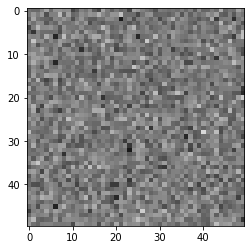

1


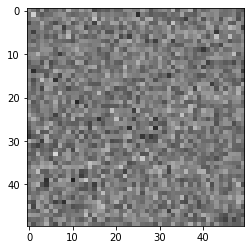

2


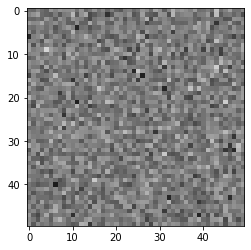

3


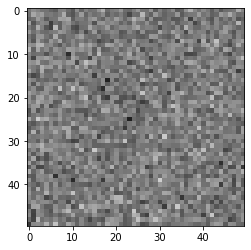

4


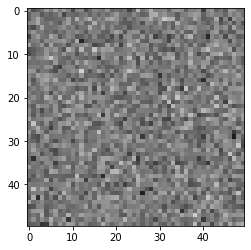

5


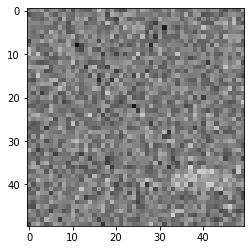

6


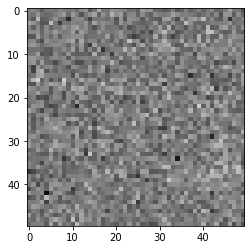

7


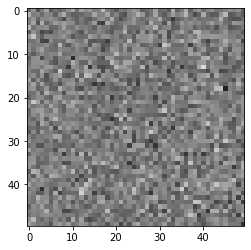

8


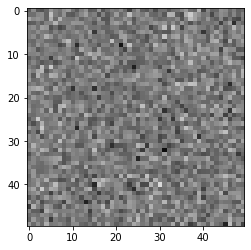

9


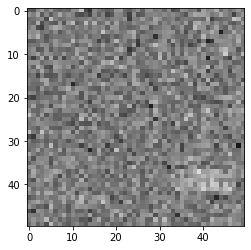

In [10]:
A_true = np.loadtxt('A_true_s.txt')
D_true= np.loadtxt('D_true_s.txt')
X_true = np.loadtxt('X_true_s.txt')
X_true_noise = np.loadtxt('X_noise_test3.txt')


for i in range(10):
    print(i)
    plt.imshow(X_true_noise[:,i].reshape((50,50)), cmap='Greys_r', vmin = 0, vmax = 255)
    
    plt.show()  

In [11]:
start_time = time.time()

d = e**(10*log(2))
l = 0 
a =  e**(21*log(2))

A_test,D_test, Keep, B = decomposition_cells_with_background(X_true_noise, L, 2500, 10**(-6), a, d, l, 3, True, True)

print("--- %s seconds ---" % (time.time() - start_time))

0 0.999
10 4.785597584720176e-05
20 3.3645771054035115e-05
30 3.657151014615577e-05
40 4.393218882369638e-05
50 5.3668167103194056e-05
60 6.573143115460027e-05
70 8.05212124419947e-05
80 9.860960884319798e-05
90 0.00012070758304304
100 0.00014767869190338115
110 0.00018056517798105908
120 0.00022061991799453404
130 0.00026934287517061864
140 0.0003285213263152255
150 0.00040027269804133775
160 0.00048708791087330526
170 0.0005918717018855907
180 0.0007179743632254508
190 0.0008692065602775702
200 0.001049825265852224
210 0.0012644743247914865
220 0.001518057830744818
230 0.0018155185695670239
240 0.0021614873937670634
250 0.0025597616475740584
260 0.003012556479078546
270 0.003519431419133128
280 0.004075647841450423
290 0.004669138035020577
300 0.005272653596084546
310 0.005812326801338562
320 0.005962657794386646
330 0.003767728463828284
340 0.0008937505872950508
350 0.00032330053811270316
360 0.0001829413761981598
370 0.00013367452652292036
380 0.00011361714144658812
390 0.000105808

255.0 0.0
255.0 0.0
255.0 0.0


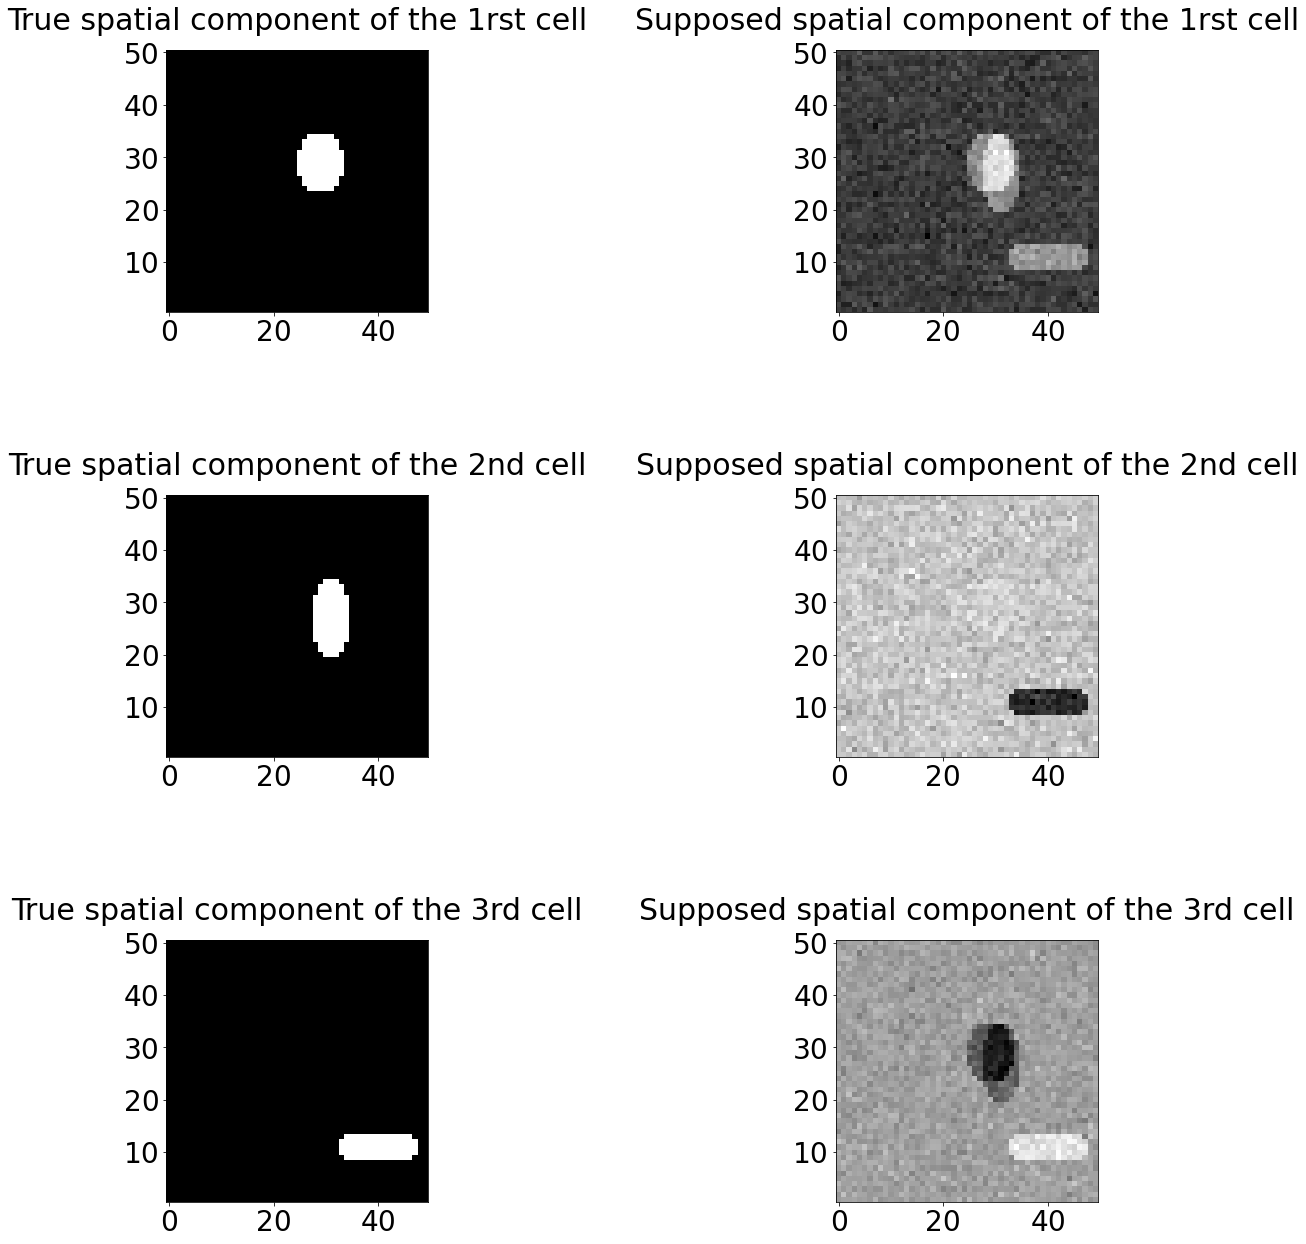

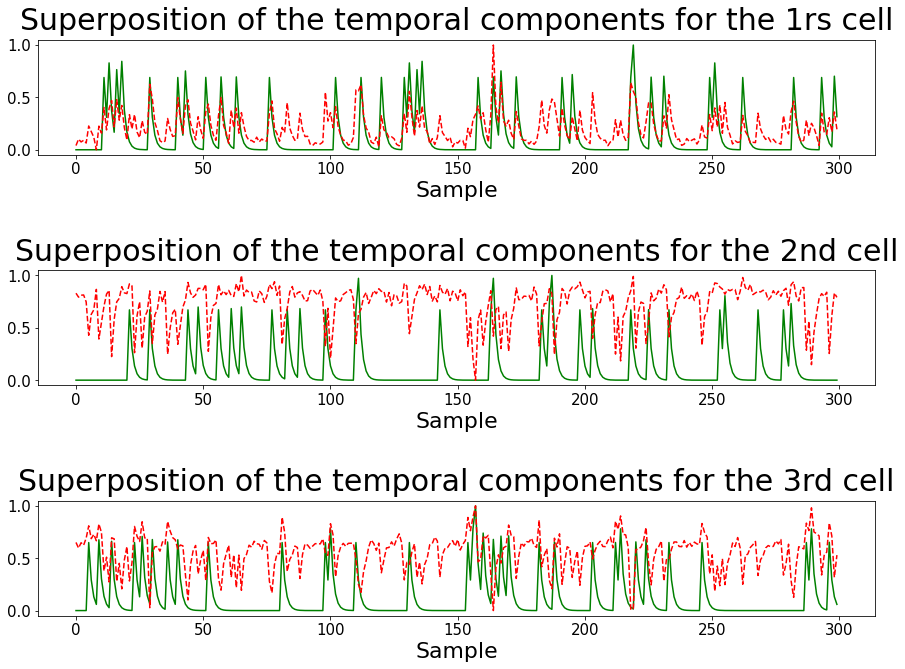

In [13]:
label_y = [0,10,20,30,40,50, 60]

A_n = np.copy(A_true)
D_n = np.copy(D_true)

for b in range(D_n.shape[1]):
    D_n[:,b]=D_n[:,b]/np.max(D_n[:,b])

for i in range(3):
    D_test[:,i] = D_test[:,i] - np.min(D_test[:,i])
    if np.max(D_test[:,i]) != 0:
        D_test[:,i] = D_test[:,i]/np.max(D_test[:,i])*255
        
D_test_n = np.copy(D_test)
A_test_n = np.copy(A_test)        

for c in range(D_test_n.shape[1]):
        if np.max(D_test_n[:,c]) != 0:
            D_test_n[:,c]=D_test_n[:,c]/np.max(D_test_n[:,c])

result = scipy.optimize.linear_sum_assignment(-np.dot(D_n.T,D_test_n))  

for change in range(result[1].shape[0]):
    if result[1][change] != a:
        D_test[:,result[1][change]]=D_test_n[:,change]*255
        A_test[result[1][change],:]=A_test_n[change,:]  
        
for i in range(3):
    print(np.max(D_test[:,i]), np.min(D_test[:,i]))
            
fig, ax = plt.subplots(3,2, figsize=(20, 20))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.5, hspace = 0.7) 

ax[0][0].imshow(D_true[:,0].reshape((50,50)), cmap='gray') #, vmin=0, vmax=255)
ax[0][0].set_title('True spatial component of the 1rst cell', fontsize = 30, pad = 20)
ax[0][0].tick_params(axis = 'x', labelsize=28)
ax[0][0].set_yticklabels(np.flipud(label_y), fontsize=28)

ax[0][1].imshow(D_test[:,0].reshape((50,50)), cmap='gray', vmin= 0, vmax=255)
ax[0][1].set_title('Supposed spatial component of the 1rst cell', fontsize = 30, pad = 20)
ax[0][1].tick_params(axis = 'x', labelsize=28)
ax[0][1].set_yticklabels(np.flipud(label_y), fontsize=28)

ax[1][0].imshow(D_true[:,1].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
ax[1][0].set_title('True spatial component of the 2nd cell', fontsize = 30, pad = 20)
ax[1][0].tick_params(axis = 'x', labelsize=28)
ax[1][0].set_yticklabels(np.flipud(label_y), fontsize=28)

ax[1][1].imshow(D_test[:,1].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
ax[1][1].set_title('Supposed spatial component of the 2nd cell', fontsize = 30, pad = 20)
ax[1][1].tick_params(axis = 'x', labelsize=28)
ax[1][1].set_yticklabels(np.flipud(label_y), fontsize=28)

ax[2][0].imshow(D_true[:,2].reshape((50,50)), cmap='gray', vmin= 0, vmax=255)
ax[2][0].set_title('True spatial component of the 3rd cell', fontsize = 30, pad = 20)
ax[2][0].tick_params(axis = 'x', labelsize=28)
ax[2][0].set_yticklabels(np.flipud(label_y), fontsize=28)

ax[2][1].imshow(D_test[:,2].reshape((50,50)), cmap='gray', vmin= 0, vmax=255)
ax[2][1].set_title('Supposed spatial component of the 3rd cell', fontsize = 30, pad = 20)
ax[2][1].tick_params(axis = 'x', labelsize=28)
ax[2][1].set_yticklabels(np.flipud(label_y), fontsize=28)

A_test_b = np.copy(A_test)
for r in range(3):
    if np.min(A_test_b[r,:])>0:
        A_test_b[r,:] = A_test_b[r,:]-np.min(A_test_b[r,:])
    if np.max(A_test_b[r,:]) != 0:
        A_test_b[r,:] = A_test_b[r,:]/np.max(A_test_b[r,:])

fig, ax = plt.subplots(3,1, figsize=(15, 10))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.2, hspace = 1) 

ax[0].plot(np.arange(0,300,1), A_true[0,:].T, 'g')
ax[0].plot(np.arange(0,300,1),  A_test_b[0,:].T, 'r--')
ax[0].set_title('Superposition of the temporal components for the 1rs cell', fontsize = 30, pad = 10)
ax[0].set_xlabel('Sample', fontsize = 22)
ax[0].tick_params(axis = 'x', labelsize=15)
ax[0].tick_params(axis = 'y', labelsize=15)

ax[1].plot(np.arange(0,300,1), A_true[1,:].T, 'g')
ax[1].plot(np.arange(0,300,1), A_test_b[1,:].T, 'r--')
ax[1].set_title('Superposition of the temporal components for the 2nd cell', fontsize=30, pad = 10)
ax[1].set_xlabel('Sample', fontsize = 22)
ax[1].tick_params(axis = 'x', labelsize=15)
ax[1].tick_params(axis = 'y', labelsize=15)

ax[2].plot(np.arange(0,300,1), A_true[2,:].T, 'g')
ax[2].plot(np.arange(0,300,1), A_test_b[2,:].T, 'r--')
ax[2].set_title('Superposition of the temporal components for the 3rd cell', fontsize=30, pad = 10)
ax[2].set_xlabel('Sample', fontsize = 22)
ax[2].tick_params(axis = 'x', labelsize=15)
ax[2].tick_params(axis = 'y', labelsize=15)


In [ ]:
print('norm D', np.linalg.norm(D_true-D_test))
print('norm D relatif', np.linalg.norm(D_true-D_test)/np.linalg.norm(D_true))

print('norm A', np.linalg.norm(A_true-A_test_b))
print('norm A relatif', np.linalg.norm(A_true-A_test_b)/np.linalg.norm(A_true))

min_A = 1
min_D = 1

mean_A = 0
mean_D = 0
for i in range(3):
    j = abs(np.corrcoef(A_true[i,:], A_test_b[i,:])[0][1])
    if np.isnan(j):
        j = 0    
    print('corr A' + str(i), j)
    
    if j<min_A:
        min_A = j
    mean_A = mean_A + j
    
    
    j = abs(np.corrcoef(D_true[:,i], D_test[:,i])[0][1])
    if np.isnan(j):
        j = 0  
    print('corr D' + str(i), j)
    
    if j < min_D:
        min_D = j
    mean_D = mean_D + j
    
    
print('min corr A ', min_A)
print('min corr D', min_D)
print('mean A corr', mean_A/3)
print('mean D corr', mean_D/3)

# Hyper-parameter selection

In [ ]:
g = 1
h = 5
k = 7


Diff_D_tot_h = np.zeros((g,h,k))
Diff_A_h = np.zeros((g,h,k))
Error_tot_h = np.zeros((g,h,k))
Diff_D_tot_nh= np.zeros((g,h,k))
Error_tot_nh = np.zeros((g,h,k))
    
Corr_A_min = np.zeros((g,h,k))
Corr_D_min = np.zeros((g,h,k))
Mean_corr_A = np.zeros((g,h,k))
Mean_corr_D = np.zeros((g,h,k))
    
Corr_X_min = np.zeros((g,h,k))
Mean_corr_X = np.zeros((g,h,k))
    
Corr_X_min_noise = np.zeros((g,h,k))
Mean_corr_X_noise = np.zeros((g,h,k))
    

    
l_num = 0
for l in np.arange(0,1,1):
    d_num = 0
    print('l', str(l))
    for d in np.arange(7,12,1):
        print('d', str(d))
        a_num = 0
        for a_ in np.arange(17,24,1):
            print('l', str(l), ' d', str(d), 'a', str(a_))

            start_time = time.time()

            A_test,D_test,Keep, B= decomposition_cells_with_background(X_true,L, 2500 , 10**(-6),e**(a*log(2)), e**(d*log(2)), 0, 3, True, True)


            for e in range(3):
                D_test[:,e] = D_test[:,e] - np.min(D_test[:,e]) 
                if np.max(D_test[:,e]) != 0 :
                    D_test[:,e] = D_test[:,e]/np.max(D_test[:,e])*255

                if np.min(A_test[e,:])>0:
                    A_test[e,:] = A_test[e,:] - np.min(A_test[e,:]) 
                if np.max(A_test[e,:]) != 0:
                    A_test[e,:] = A_test[e,:]/np.max(A_test[e,:])

            A_n = np.copy(A_true)
            D_n = np.copy(D_true)

            for b in range(D_n.shape[1]):
                D_n[:,b]=D_n[:,b]/np.max(D_n[:,b])

            D_test_n = np.copy(D_test)
            for c in range(D_test_n.shape[1]):
                if np.max(D_test_n[:,c]) != 0:
                    D_test_n[:,c]=D_test_n[:,c]/np.max(D_test_n[:,c])

            result = scipy.optimize.linear_sum_assignment(-np.dot(D_n.T,D_test_n))  

            for change in range(result[1].shape[0]):
                if result[1][change] != a:
                    D_true[:,result[1][change]]=D_n[:,change]*255
                    A_true[result[1][change],:]=A_n[change,:]

            X_new = np.dot(D_true, A_true)
            X_new = X_new/np.max(X_new)*255
            
            X_obt = np.dot(D_test,A_test)
            X_obt = X_obt/np.max(X_obt)

            Diff_D_tot_h[l_num][d_num][a_num] = (np.linalg.norm(D_true[:,0]-D_test[:,0],2) + np.linalg.norm(D_true[:,1]-D_test[:,1],2) + np.linalg.norm(D_true[:,2]-D_test[:,2],2))
            Error_tot_h[l_num][d_num][a_num]= (np.linalg.norm(X_new-X_obt,2))  
            Diff_A_h[l_num][d_num][a_num] = (np.linalg.norm(A_true[0,:]-A_test[0,:],2) + np.linalg.norm(A_true[1,:]-A_test[1,:],2) + np.linalg.norm(A_true[2,:]-A_test[2,:],2))


            min_A = 1
            min_D = 1

            mean_A = 0
            mean_D = 0
            for i in range(3):
                j = np.abs(np.corrcoef(A_true[i,:], A_test[i,:])[0][1])
                if np.isnan(j):
                    j = 0

                if j<min_A:
                    min_A = j
                mean_A = mean_A + j
                j = np.abs(np.corrcoef(D_true[:,i], D_test[:,i])[0][1])
                if np.isnan(j):
                    j = 0
                if j < min_D:
                    min_D = j
                mean_D = mean_D + j


            Corr_A_min[l_num][d_num][a_num] = (min_A)
            Corr_D_min[l_num][d_num][a_num] = (min_D)
            Mean_corr_A[l_num][d_num][a_num] = (mean_A/3)
            Mean_corr_D[l_num][d_num][a_num] = (mean_D/3)


            print("--- %s seconds ---" % (time.time() - start_time))
            a_num = a_num +1
        d_num = d_num +1

    l_num = l_num +1
       
    print('end') #4